<a href="https://colab.research.google.com/github/bdmarvin1/log-file-analysis/blob/main/Chargebee_Log_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enterprise Log File Analysis: Chargebee Case Study
This notebook analyzes one year of server log data to diagnose crawl budget waste, identify spider traps, and explain indexing issues.

**Objective:** Identify why some pages are "Crawled - Currently Not Indexed" and optimize Googlebot's efficiency.

## Phase 1: Environment & Dependency Setup

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import socket
import gc
from datetime import datetime
from google.colab import auth
import gspread
from gspread.utils import rowcol_to_a1
from google.auth import default

# Mount Google Drive
drive.mount('/content/drive')

# Constants
LOGS_PATH = '/content/drive/MyDrive/Chargebee_Logs/'
OUTPUT_SHEET_NAME = 'Chargebee_Audit_Findings'

# iPullRank Brand Colors
IPR_YELLOW = '#FCD307'
IPR_BLUE = '#2A52BE'
IPR_BLACK = '#000000'
IPR_GREY = '#333333'
IPR_LIGHT_GREY = '#CCCCCC'

def get_ipr_colors(n, values=None):
    if n <= 0: return []
    grey_start = 51
    grey_end = 204
    if values is not None:
        v = np.array(values)
        if len(v) == 0: return []
        sorted_indices = np.argsort(v)[::-1]
        colors = ['#CCCCCC'] * len(v)
        num_greys = max(1, n - 2)
        grey_values = np.linspace(grey_start, grey_end, num_greys)
        for i, idx in enumerate(sorted_indices):
            if i == 0: colors[idx] = IPR_YELLOW
            elif i == 1: colors[idx] = IPR_BLUE
            else:
                grey_val = int(grey_values[i-2])
                colors[idx] = '#%02x%02x%02x' % (grey_val, grey_val, grey_val)
        return colors
    num_greys = max(1, n - 2)
    grey_values = np.linspace(grey_start, grey_end, num_greys)
    colors = []
    for i in range(n):
        if i == 0: colors.append(IPR_YELLOW)
        elif i == 1: colors.append(IPR_BLUE)
        else:
            grey_val = int(grey_values[i-2])
            colors.append('#%02x%02x%02x' % (grey_val, grey_val, grey_val))
    return colors


def calculate_summary_stats(data, global_mean=None, global_std=None):
    """Calculates summary statistics and SD band counts."""
    if data is None or len(data) == 0:
        return pd.Series(dtype=float)

    # Basic Stats
    stats = {
        'Min': float(data.min()),
        'Max': float(data.max()),
        'Mean': float(data.mean()),
        'Median': float(data.median()),
        'Std Dev': float(data.std()),
        'Total Count': int(len(data))
    }

    # Use global stats if provided, otherwise use data's own stats
    m = float(global_mean) if global_mean is not None else float(data.mean())
    s = float(global_std) if global_std is not None else float(data.std())

    if s and s > 0:
        stats['Above +2SD'] = int(len(data[data > m + 2*s]))
        stats['+1SD to +2SD'] = int(len(data[(data > m + s) & (data <= m + 2*s)]))
        stats['-1SD to +1SD'] = int(len(data[(data >= m - s) & (data <= m + s)]))
        stats['-2SD to -1SD'] = int(len(data[(data < m - s) & (data >= m - 2*s)]))
        stats['Below -2SD'] = int(len(data[data < m - 2*s]))
    else:
        # If no standard deviation, all items are within 1SD of mean
        stats['Above +2SD'] = 0
        stats['+1SD to +2SD'] = 0
        stats['-1SD to +1SD'] = int(len(data))
        stats['-2SD to -1SD'] = 0
        stats['Below -2SD'] = 0

    return pd.Series(stats)

sns.set(style='whitegrid', palette=[IPR_BLUE, IPR_YELLOW, IPR_GREY])

Mounted at /content/drive


## Phase 2: Data Ingestion (Memory Optimized)
We process logs in chunks and filter for 'Googlebot' immediately to keep the memory footprint small.

In [2]:
def ingest_logs(directory_path, chunk_size=50000):
    all_files = glob.glob(os.path.join(directory_path, "*.csv"))
    if not all_files:
        print(f"No CSV files found in {directory_path}")
        return pd.DataFrame()

    googlebot_data = []
    rows_kept = 0
    total_rows_processed = 0

    # Columns we actually need to save memory
    use_cols = ['_time', 'useragent', 'uri_path', 'uri_query', 'status', 'bytes_sent', 'clientip', 'method', 'time_taken']

    for file in all_files:
        print(f"Processing {file}...")
        try:
            # Read in chunks to avoid OOM
            for chunk in pd.read_csv(file, usecols=use_cols, chunksize=chunk_size, low_memory=False):
                total_rows_processed += len(chunk)
                # Filter for Googlebot (case-insensitive)
                filtered_chunk = chunk[chunk['useragent'].str.contains("google", case=False, na=False)].copy()
                rows_kept += len(filtered_chunk)
                googlebot_data.append(filtered_chunk)

                # Aggressive garbage collection
                del chunk
                gc.collect()
        except Exception as e:
            print(f"Error processing {file}: {e}")

    if not googlebot_data:
        return pd.DataFrame()

    df = pd.concat(googlebot_data, ignore_index=True)
    print(f"Ingestion complete. Total Googlebot rows: {len(df)}")
    return df

df_raw = ingest_logs(LOGS_PATH)

Processing /content/drive/MyDrive/Chargebee_Logs/21. 06Augto10Aug.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/22. 11Augto15Aug.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/7. 01Junto05Jun.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/5. may26-30.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/18. 21Julto25Jul.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/9. 11Junto15Jun.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/16. Jul11toJul15.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/8. 06Junto10Jun.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/1. 12Aprto22Apr.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/11. 19jun.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/19. 26Julto31Jul.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/6. May31.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/13. 24jun.csv...
Processing /content/drive/MyDrive/Chargebee_Logs/17. 16Julto20Jul.csv...
Processin

## Phase 3: Data Cleaning & IP Verification

In [3]:
def verify_googlebot_ip(ip):
    """Performs Double-Reverse DNS lookup to verify Googlebot."""
    try:
        host = socket.gethostbyaddr(ip)[0]
        if not (host.endswith('.googlebot.com') or host.endswith('.google.com') or host.endswith('.googleusercontent.com')):
            return False

        addr = socket.gethostbyname(host)
        return addr == ip
    except (socket.herror, socket.gaierror):
        return False

def clean_data(df):
    if df.empty:
        return df

    # 1. Timestamp Conversion
    df['_time'] = pd.to_datetime(df['_time'])
    df.set_index('_time', inplace=True)

    # 2. IP Verification (Sample check if dataset is huge, or all unique IPs)
    unique_ips = df['clientip'].unique()
    print(f"Verifying {len(unique_ips)} unique IPs...")
    ip_map = {ip: verify_googlebot_ip(ip) for ip in unique_ips}
    df['is_verified_bot'] = df['clientip'].map(ip_map)

    # 3. File Type Categorization
    def get_file_type(path):
        if pd.isna(path): return 'Other'
        ext = os.path.splitext(path)[1].lower()
        if ext in ['', '.html', '.htm']: return 'HTML'
        if ext == '.js': return 'JS'
        if ext == '.css': return 'CSS'
        if ext in ['.jpg', '.jpeg', '.png', '.gif', '.svg', '.webp']: return 'Image'
        if ext in ['.json', '.xml']: return 'Data'
        return 'Other'

    df['file_type'] = df['uri_path'].apply(get_file_type)

    # 4. URL Normalization
    df['full_url'] = df['uri_path'] + df['uri_query'].fillna('')

    return df

df = clean_data(df_raw)
if not df.empty:
    print(f"Verified Bots: {df['is_verified_bot'].sum()} / {len(df)}")

Verifying 256 unique IPs...
Verified Bots: 0 / 720452


## Phase 4: Core Analysis Modules

In [4]:
# --- Global Benchmarks for Summary Statistics ---
# These are used as reference points for all SD band calculations

# 1. Daily Hits Benchmarks (All bots combined)
total_daily_hits = df.resample('D').size()
global_hit_mean = float(total_daily_hits.mean())
global_hit_std = float(total_daily_hits.std())

# 2. Weekly Hits Benchmarks (Only full weeks)
days_per_week = df.index.to_series().resample('W').apply(lambda x: x.dt.date.nunique())
full_weeks = days_per_week[days_per_week == 7].index
total_weekly_hits = df.resample('W').size().loc[full_weeks]
global_weekly_hit_mean = float(total_weekly_hits.mean())
global_weekly_hit_std = float(total_weekly_hits.std())

# 3. Site-Wide Performance Benchmarks (All file types)
global_latency_mean = float(df['time_taken'].mean())
global_latency_std = float(df['time_taken'].std())
global_bandwidth_mean = float(df['bytes_sent'].mean())
global_bandwidth_std = float(df['bytes_sent'].std())

print(f"Global Daily Hit Mean: {global_hit_mean:.2f} (SD: {global_hit_std:.2f})")
print(f"Global Site Latency Mean: {global_latency_mean:.2f}ms (SD: {global_latency_std:.2f})")
print(f"Global Site Bandwidth Mean: {global_bandwidth_mean:.2f} bytes (SD: {global_bandwidth_std:.2f})")


Global Daily Hit Mean: 5038.13 (SD: 700.96)
Global Site Latency Mean: 2282.28ms (SD: 6214.02)
Global Site Bandwidth Mean: 22453.99 bytes (SD: 379025.15)


### Module A: Crawl Volume & Frequency

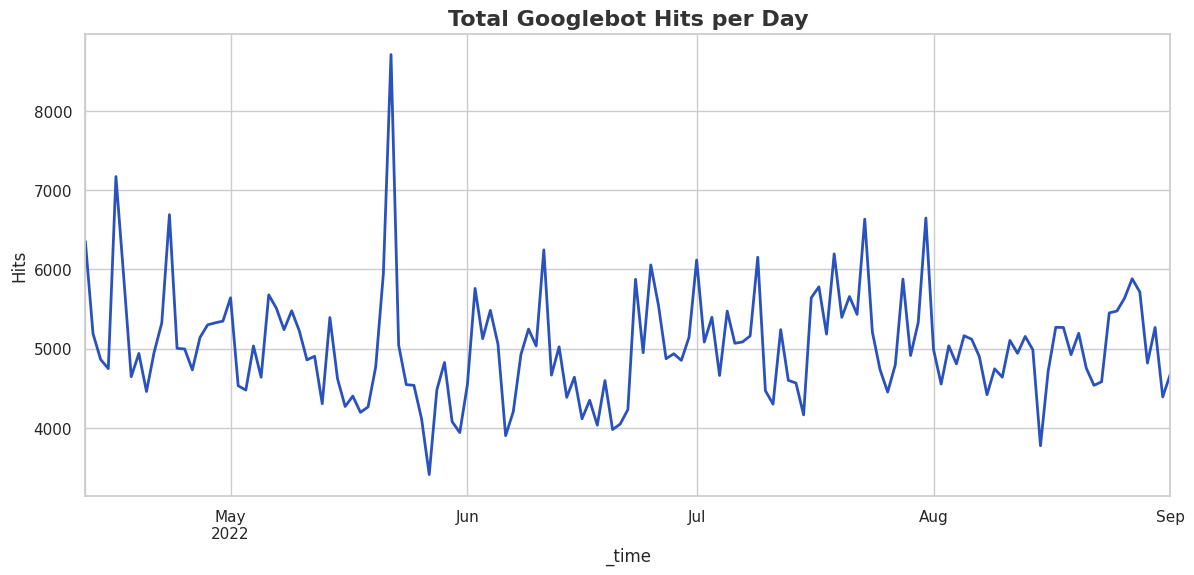

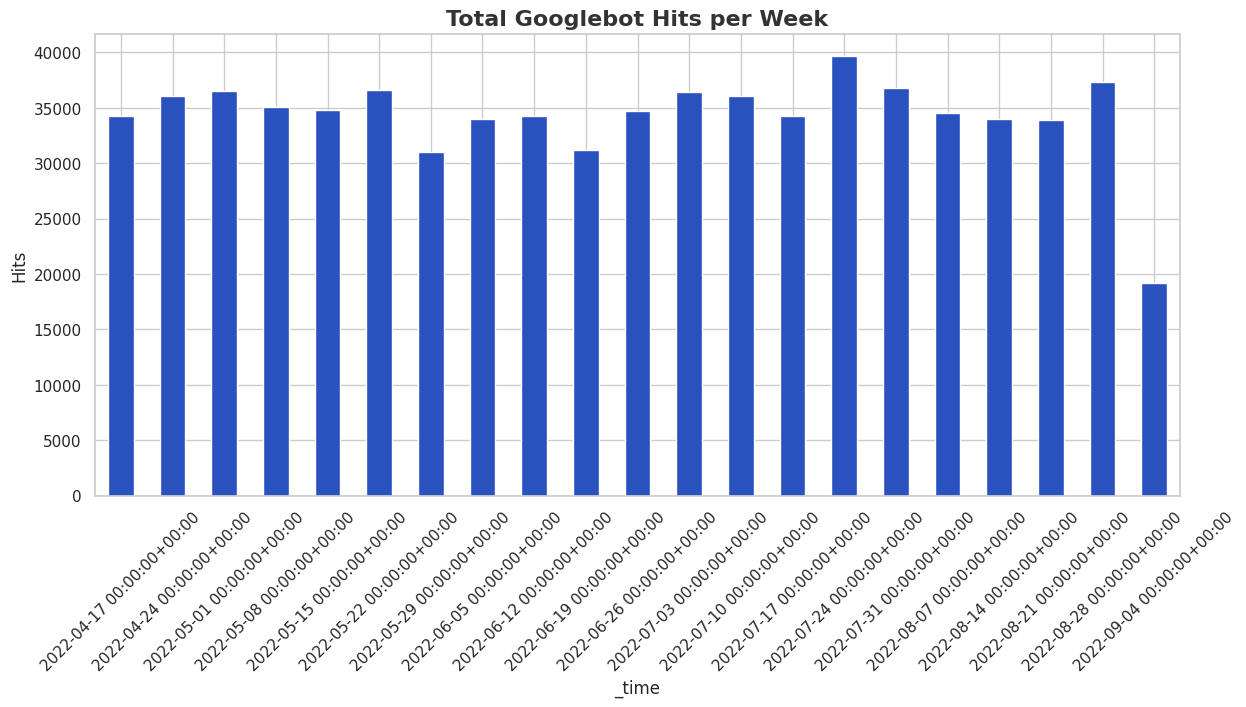

Daily Hits Summary Stats:


,Min,Max,Mean,Median,Std Dev,Total Count,Above +2SD,+1SD to +2SD,-1SD to +1SD,-2SD to -1SD,Below -2SD
Total Daily Hits,3412.0,8711.0,5038.125874,4987.0,700.959361,143.0,5.0,13.0,107.0,17.0,1.0



Weekly Hits Summary Stats:


,Min,Max,Mean,Median,Std Dev,Total Count,Above +2SD,+1SD to +2SD,-1SD to +1SD,-2SD to -1SD,Below -2SD
Total Weekly Hits,19161.0,39713.0,34307.238095,34696.0,3977.838093,21.0,0.0,1.0,19.0,0.0,1.0


In [5]:
# --- Total Hits Analysis (Daily & Weekly) ---

# 1. Daily Total Hits
plt.figure(figsize=(14, 6))
total_daily_hits.plot(color=IPR_BLUE, linewidth=2)
plt.title('Total Googlebot Hits per Day', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.ylabel('Hits')
plt.show()

daily_hits_summary = calculate_summary_stats(total_daily_hits, global_hit_mean, global_hit_std)
daily_hits_summary_df = pd.DataFrame(daily_hits_summary).T
daily_hits_summary_df.index = ['Total Daily Hits']

# 2. Weekly Total Hits
plt.figure(figsize=(14, 6))
total_weekly_hits.plot(kind='bar', color=IPR_BLUE)
plt.title('Total Googlebot Hits per Week', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.ylabel('Hits')
plt.xticks(rotation=45)
plt.show()

weekly_hits_summary = calculate_summary_stats(total_weekly_hits, global_weekly_hit_mean, global_weekly_hit_std)
weekly_hits_summary_df = pd.DataFrame(weekly_hits_summary).T
weekly_hits_summary_df.index = ['Total Weekly Hits']

print("Daily Hits Summary Stats:")
display(daily_hits_summary_df)
print("\nWeekly Hits Summary Stats:")
display(weekly_hits_summary_df)


/tmp/ipython-input-3474791607.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bot_counts.index, y=bot_counts.values, palette=colors)


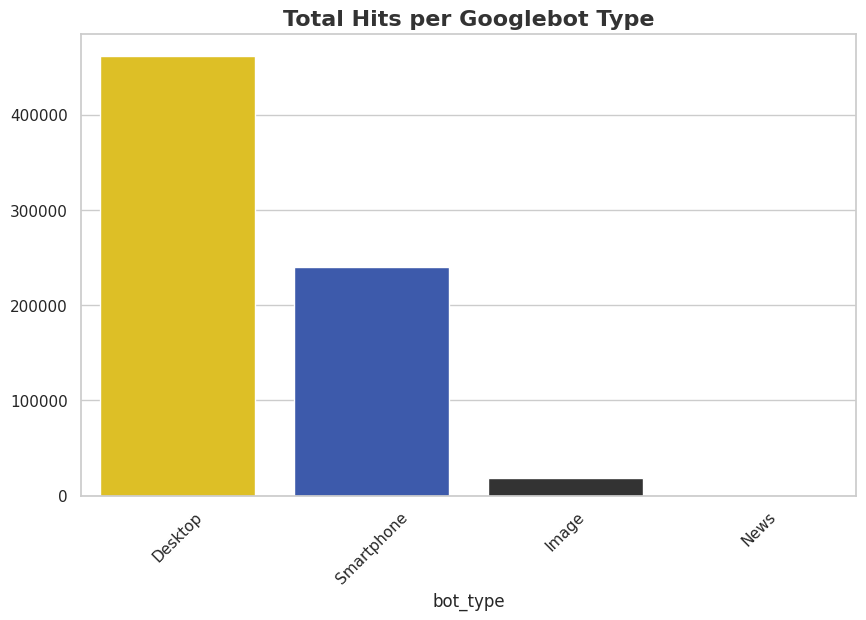

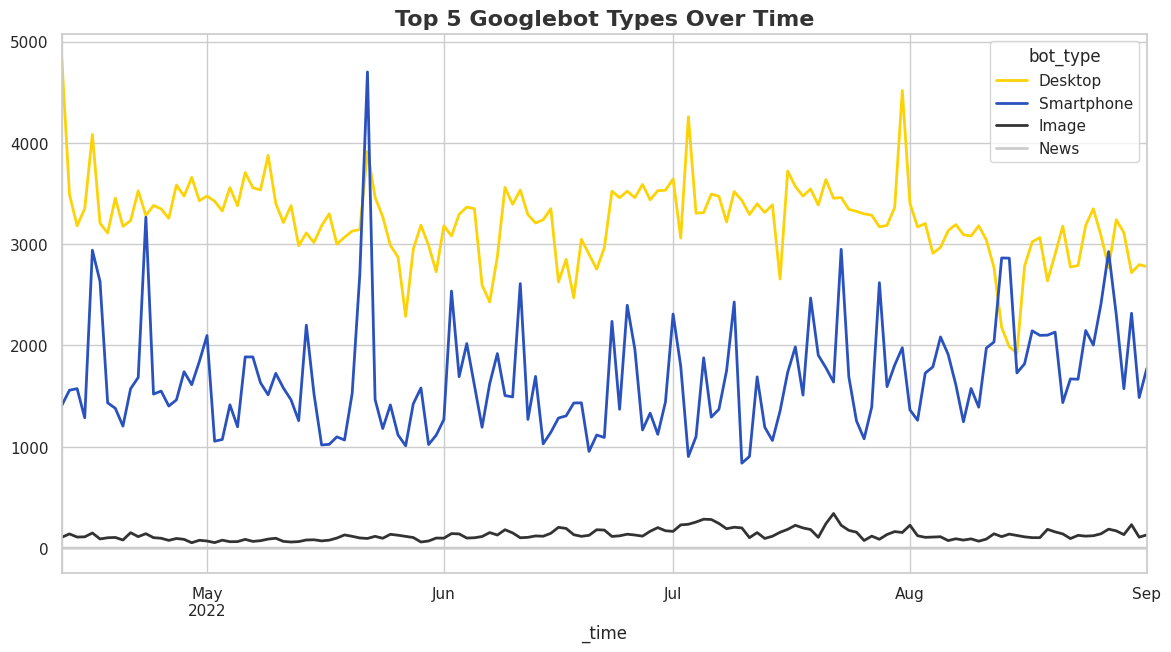

Bot Type Summary Statistics (Relative to Global Daily Average):


,Min,Max,Mean,Median,Std Dev,Total Count,Above +2SD,+1SD to +2SD,-1SD to +1SD,-2SD to -1SD,Below -2SD
Desktop,1923.0,4837.0,3229.657343,3270.0,396.626693,143.0,0.0,0.0,2.0,9.0,132.0
Image,53.0,341.0,130.160839,117.0,52.334064,143.0,0.0,0.0,0.0,0.0,143.0
News,0.0,1.0,0.027972,0.0,0.165472,143.0,0.0,0.0,0.0,0.0,143.0
Smartphone,838.0,4700.0,1678.279720,1574.0,557.740846,143.0,0.0,0.0,1.0,0.0,142.0


In [6]:
import re

def get_bot_type(ua):
    ua = str(ua)
    if re.search(r'Googlebot-Image', ua, re.I): return 'Image'
    if re.search(r'Googlebot-Video', ua, re.I): return 'Video'
    if re.search(r'Googlebot-News', ua, re.I): return 'News'
    if re.search(r'Storebot-Google', ua, re.I): return 'StoreBot'
    if re.search(r'AdsBot-Google', ua, re.I): return 'AdsBot'
    if re.search(r'Mediapartners-Google', ua, re.I): return 'AdSense'
    if re.search(r'Google-InspectionTool', ua, re.I): return 'Inspection Tool'
    if re.search(r'Googlebot', ua, re.I):
        if re.search(r'Mobile|Android|iPhone', ua, re.I): return 'Smartphone'
        return 'Desktop'
    return 'Other Google/Unknown'

df['bot_type'] = df['useragent'].apply(get_bot_type)
bot_counts = df['bot_type'].value_counts()

plt.figure(figsize=(10, 6))
colors = get_ipr_colors(len(bot_counts), values=bot_counts.values)
sns.barplot(x=bot_counts.index, y=bot_counts.values, palette=colors)
plt.title('Total Hits per Googlebot Type', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.xticks(rotation=45)
plt.show()

top_5_bots = bot_counts.head(5).index.tolist()
bot_time_series = df[df['bot_type'].isin(top_5_bots)].groupby(['bot_type']).resample('D').size().unstack(0).fillna(0)
plt.figure(figsize=(14, 7))
line_colors = get_ipr_colors(len(top_5_bots), values=[bot_counts[b] for b in top_5_bots])
bot_time_series[top_5_bots].plot(ax=plt.gca(), color=line_colors, linewidth=2)
plt.title('Top 5 Googlebot Types Over Time', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.show()
# Calculate global benchmarks for daily hits

# Calculate summary statistics for Top Bot Types
bot_summary_stats = {}
for bot_type in bot_time_series.columns:
    bot_summary_stats[bot_type] = calculate_summary_stats(bot_time_series[bot_type], global_hit_mean, global_hit_std)
bot_summary_df = pd.DataFrame(bot_summary_stats).T

print("Bot Type Summary Statistics (Relative to Global Daily Average):")
display(bot_summary_df)


### Module A.2: robots.txt Analysis
This module tracks how many times Googlebot requested the robots.txt file and what status codes were returned.

In [ ]:
# --- robots.txt Analysis ---
print("Analyzing robots.txt hits...")
robots_df = df[df['uri_path'].str.contains('robots.txt', na=False, case=False)]
robots_summary_df = robots_df.groupby(['uri_path', 'status']).size().reset_index(name='hits')

display(robots_summary_df)

### Module B: Status Code Health

In [7]:
# --- Cache Lifecycle & New Page Analysis ---

print("Analyzing page-level cache transitions...")

# Sort by time to analyze sequence
df_sorted = df.sort_index()

# 1. Average 200s before first 304
def calc_200s_before_304(group):
    status_list = group['status'].tolist()
    try:
        first_304_idx = status_list.index(304)
        return status_list[:first_304_idx].count(200)
    except ValueError:
        return None

page_transitions = df_sorted.groupby('full_url').apply(calc_200s_before_304)
pages_with_304 = page_transitions.dropna()
avg_200s_before_304 = pages_with_304.mean() if not pages_with_304.empty else 0

# 2. "New Page" Analysis
first_hits = df_sorted.groupby('full_url').head(1)
new_page_urls = first_hits[first_hits['status'] == 200]['full_url'].unique()

new_page_data = df_sorted[df_sorted['full_url'].isin(new_page_urls)]
new_page_ever_304 = new_page_data.groupby('full_url')['status'].apply(lambda x: 304 in x.values)
pct_new_pages_caching = (new_page_ever_304.sum() / len(new_page_ever_304) * 100) if len(new_page_ever_304) > 0 else 0

# 3. Potential Hits Eliminated (Theoretical Savings)
# Logic: Max(0, Count of 200 OK responses - 2) per URL
url_200_counts = df[df['status'] == 200]['full_url'].value_counts()
potential_eliminated_hits = url_200_counts.apply(lambda x: max(0, x - 2)).sum()
pct_total_hits_savable = (potential_eliminated_hits / len(df) * 100)

# Summary Table
cache_summary_df = pd.DataFrame({
    'Metric': [
        'Avg 200s before first 304',
        'Total Pages analyzed for 304 transition',
        'Total "New Pages" (Start with 200)',
        'New Pages that eventually got a 304',
        '% of New Pages that cached',
        'Potential Hits Eliminated (Automated 304 Implementation)',
        '% of Total Hits theoretically eliminable'
    ],
    'Value': [
        avg_200s_before_304,
        len(pages_with_304),
        len(new_page_ever_304),
        new_page_ever_304.sum(),
        pct_new_pages_caching,
        potential_eliminated_hits,
        pct_total_hits_savable
    ]
})

print(f"Average 200s before 304: {avg_200s_before_304:.2f}")
print(f"Percentage of new pages that eventually show a 304: {pct_new_pages_caching:.2f}%")
print(f"Potential hits eliminated: {potential_eliminated_hits:,} ({pct_total_hits_savable:.2f}% of total crawl volume)")
display(cache_summary_df)


Analyzing page-level cache transitions...


/tmp/ipython-input-2370331503.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  page_transitions = df_sorted.groupby('full_url').apply(calc_200s_before_304)


Average 200s before 304: 1.66
Percentage of new pages that eventually show a 304: 22.73%
Potential hits eliminated: 627,974 (87.16% of total crawl volume)


,Metric,Value
0,Avg 200s before first 304,1.662437
1,Total Pages analyzed for 304 transition,17573.000000
2,"Total ""New Pages"" (Start with 200)",47823.000000
3,New Pages that eventually got a 304,10869.000000
4,% of New Pages that cached,22.727558
5,Potential Hits Eliminated (Automated 304 Imple...,627974.000000
6,% of Total Hits theoretically eliminable,87.163892


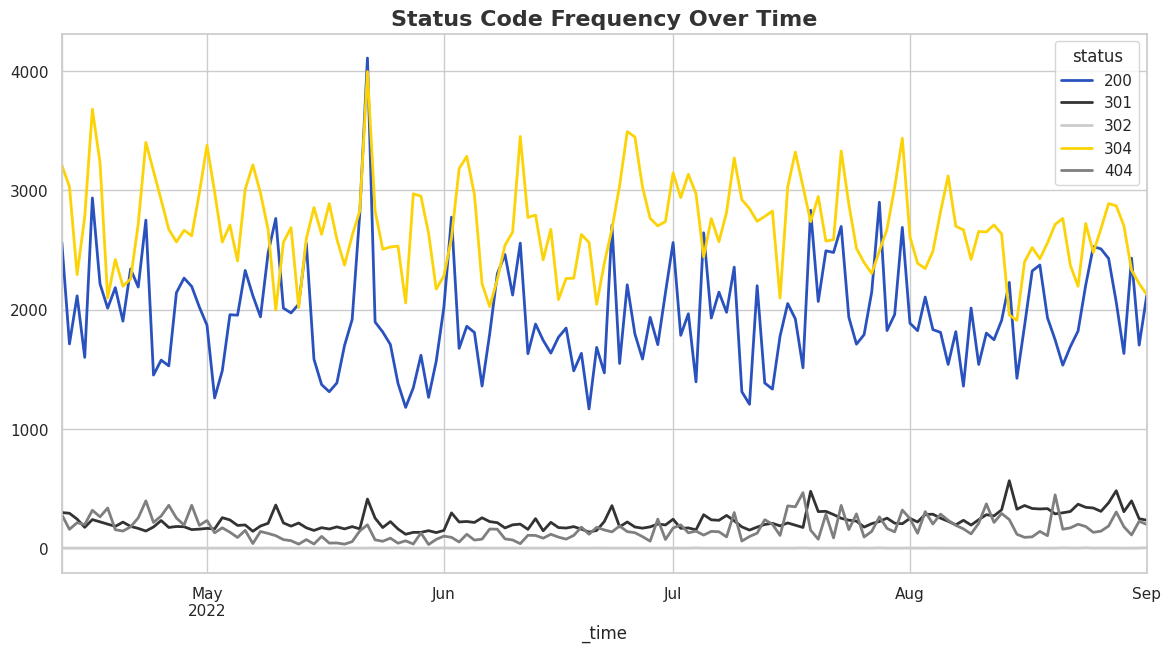

Status Code Summary Statistics (Relative to Global Daily Average):


,Min,Max,Mean,Median,Std Dev,Total Count,Above +2SD,+1SD to +2SD,-1SD to +1SD,-2SD to -1SD,Below -2SD
200,1167.0,4109.0,1953.811189,1903.0,450.738923,143.0,0.0,0.0,0.0,1.0,142.0
301,116.0,565.0,226.979021,211.0,75.020511,143.0,0.0,0.0,0.0,0.0,143.0
302,0.0,3.0,0.216783,0.0,0.595048,143.0,0.0,0.0,0.0,0.0,143.0
304,1910.0,3996.0,2695.468531,2673.0,377.343211,143.0,0.0,0.0,0.0,2.0,141.0
404,30.0,465.0,161.650350,140.0,93.015769,143.0,0.0,0.0,0.0,0.0,143.0


In [8]:
status_summary = df.groupby(['status', 'file_type']).size().unstack(fill_value=0)
status_totals = df['status'].value_counts()

status_time_series = df.groupby(['status']).resample('D').size().unstack(0).fillna(0)
plt.figure(figsize=(14, 7))
st_colors = get_ipr_colors(len(status_totals), values=status_totals.values)
st_map = dict(zip(status_totals.index, st_colors))
line_colors = [st_map.get(s, '#CCCCCC') for s in status_time_series.columns]
status_time_series.plot(ax=plt.gca(), color=line_colors, linewidth=2)
plt.title('Status Code Frequency Over Time', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.show()
# Calculate summary statistics for Status Codes
status_code_summary_stats = {}
for status_code in status_time_series.columns:
    status_code_summary_stats[status_code] = calculate_summary_stats(status_time_series[status_code], global_hit_mean, global_hit_std)
status_code_summary_df = pd.DataFrame(status_code_summary_stats).T

print("Status Code Summary Statistics (Relative to Global Daily Average):")
display(status_code_summary_df)


### Module C: Spider Trap Detection

In [10]:
from urllib.parse import parse_qs

def analyze_spider_traps(df, threshold=50):
    traps = df.groupby('uri_path').agg(
        unique_variations=('full_url', 'nunique'),
        total_hits=('full_url', 'count'),
        sample_urls=('full_url', lambda x: list(x.unique()[:3]))
    ).reset_index()
    top_traps_summary = traps[traps['unique_variations'] > threshold].sort_values(by='unique_variations', ascending=False)
    trap_details = []
    filter_keywords = ['sort', 'filter', 'price', 'color', 'size', 'category', 'page', 'offset', 'limit', 'order']
    doc_extensions = ['.pdf', '.doc', '.docx', '.xls', '.xlsx', '.csv']
    for _, row in top_traps_summary.iterrows():
        path = row['uri_path']
        trap_data = df[df['uri_path'] == path]

        # Calculate Avg Latency and Total Bytes for each trap
        avg_latency = trap_data['time_taken'].mean()
        total_bytes = trap_data['bytes_sent'].sum()

        param_counts = {}; combo_counts = {}
        for query in trap_data['uri_query'].dropna():
            params = parse_qs(query.lstrip('?'))
            for p in params.keys(): param_counts[p] = param_counts.get(p, 0) + 1
            combo = '+'.join(sorted(params.keys()))
            if combo: combo_counts[combo] = combo_counts.get(combo, 0) + 1
        is_doc = any(path.lower().endswith(ext) for ext in doc_extensions)
        found_filters = [p for p in param_counts.keys() if any(k in p.lower() for k in filter_keywords)]
        trap_details.append({
            'uri_path': path,
            'Variations': row['unique_variations'],
            'Hits': row['total_hits'],
            'Avg Latency': avg_latency, # Added Avg Latency
            'Total Bytes': total_bytes, # Added Total Bytes
            'IsDoc': 'Yes' if is_doc else 'No',
            'FileTypes': trap_data['file_type'].value_counts().to_dict(),
            'Top Bloat Params': sorted(param_counts.items(), key=lambda x: x[1], reverse=True)[:3],
            'Top Combos': sorted(combo_counts.items(), key=lambda x: x[1], reverse=True)[:3],
            'FilterParams': found_filters,
            'URL Samples': row['sample_urls']
        })
    return pd.DataFrame(trap_details)

trap_details_df = analyze_spider_traps(df)
display(trap_details_df.head(10))
# Summary statistics for the Spider Trap Analysis table
trap_summary_df = pd.DataFrame({
    'Variations': calculate_summary_stats(trap_details_df['Variations']),
    'Avg Latency': calculate_summary_stats(trap_details_df['Avg Latency']),
    'Total Bytes': calculate_summary_stats(trap_details_df['Total Bytes'])
}).T
print("Spider Trap Summary Statistics:")
display(trap_summary_df)


,uri_path,Variations,Hits,Avg Latency,Total Bytes,IsDoc,FileTypes,Top Bloat Params,Top Combos,FilterParams,URL Samples
0,/docs/2.0/,734,1735,848.766571,10851674,No,{'HTML': 1735},"[(__hstc, 856), (__hssc, 856), (__hsfp, 856)]","[(__hsfp+__hssc+__hstc, 488), (__hsfp+__hssc+_...",[],[/docs/2.0/ref=navbar&__hstc=46579384.fcb617fb...
1,/docs/,723,1584,248.491162,3125850,No,{'HTML': 1584},"[(__hstc, 841), (__hssc, 841), (__hsfp, 841)]","[(__hsfp+__hssc+__hstc, 475), (__hsfp+__hssc+_...",[],[/docs/ref=navbar&__hstc=46579384.fcb617fbd39b...
2,/,315,8228,3955.118133,177139271,No,{'HTML': 8228},"[(utm_source, 362), (utm_campaign, 302), (utm_...","[(__hsfp+__hssc+__hstc, 274), (utm_campaign+ut...",[],"[/, /ref=heysummit, /utm_source=cbemail&utm_me..."
3,/analytics/info.txt,224,3145,264.316375,6806485,No,{'Other': 3145},"[(typekit, 3139), (jquery, 3139), (webjs, 3139)]",[(jquery+overall+swiftype+tpjs+type+typekit+we...,[],[/analytics/info.txttypekit=1&jquery=3&webjs=3...
4,/trial-signup/,209,940,812.830851,7610150,No,{'HTML': 940},"[(__hstc, 221), (__hssc, 221), (__hsfp, 221)]","[(__hsfp+__hssc+__hstc, 198), (ref, 186), (utm...",[],[/trial-signup/utm_source=capterra-display&utm...
5,/trial-signup.html,175,233,236.081545,699186,No,{'HTML': 233},"[(__hstc, 177), (__hssc, 177), (__hsfp, 177)]","[(__hsfp+__hssc+__hstc, 177), (utm_campaign+ut...",[],[/trial-signup.htmlutm_source=capterra-display...
6,/tutorials/,140,208,1127.062500,1393698,No,{'HTML': 208},"[(__hstc, 176), (__hssc, 176), (__hsfp, 176)]","[(__hsfp+__hssc+__hstc, 176), (ref, 1)]",[],"[/tutorials/, /tutorials/__hstc=42340538.2f3f3..."
7,/privacy/,125,274,10221.463504,15634554,No,{'HTML': 274},"[(__hstc, 152), (__hssc, 152), (__hsfp, 152)]","[(__hsfp+__hssc+__hstc, 152), (tid, 3), (affil...",[offset],[/privacy/__hstc=51647990.908a81f35b721d22a691...
8,/resources/glossaries/saas-metrics/churn/,101,137,431.270073,303961,No,{'HTML': 137},"[(__hstc, 119), (__hssc, 119), (__hsfp, 119)]","[(__hsfp+__hssc+__hstc, 119)]",[],[/resources/glossaries/saas-metrics/churn/__hs...
9,/resources/glossaries/what-is-churn-rate/,101,4744,1965.054806,54230418,No,{'HTML': 4744},"[(__hstc, 138), (__hssc, 138), (__hsfp, 138)]","[(__hsfp+__hssc+__hstc, 138)]",[],"[/resources/glossaries/what-is-churn-rate/, /r..."


Spider Trap Summary Statistics:


,Min,Max,Mean,Median,Std Dev,Total Count,Above +2SD,+1SD to +2SD,-1SD to +1SD,-2SD to -1SD,Below -2SD
Variations,61.000000,7.340000e+02,1.973529e+02,1.010000e+02,2.115990e+02,17.0,2.0,0.0,15.0,0.0,0.0
Avg Latency,236.081545,1.022146e+04,2.306601e+03,8.487666e+02,3.125360e+03,17.0,1.0,2.0,14.0,0.0,0.0
Total Bytes,303961.000000,1.771393e+08,2.213292e+07,6.806485e+06,4.354893e+07,17.0,1.0,0.0,16.0,0.0,0.0


### Module D: Rendering Budget Impact

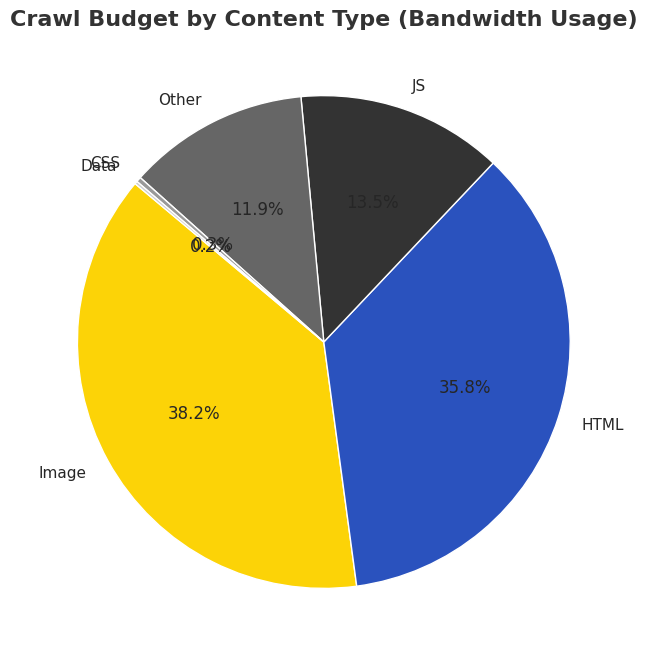

Rendering Budget Summary Statistics (Bandwidth per Request vs Site Average):


,Min,Max,Mean,Median,Std Dev,Total Count,Above +2SD,+1SD to +2SD,-1SD to +1SD,-2SD to -1SD,Below -2SD
file_type,,,,,,,,,,,
HTML,145.0,563432.0,15737.842907,3817.0,2.095314e+04,368063.0,0.0,40.0,368023.0,0.0,0.0
JS,144.0,463998.0,8479.473677,3751.0,1.925876e+04,258345.0,0.0,48.0,258297.0,0.0,0.0
Image,139.0,11771586.0,103152.457916,9841.0,3.998775e+05,59976.0,1287.0,1320.0,57369.0,0.0,0.0
CSS,146.0,59341.0,4044.551735,3751.0,6.185132e+03,13144.0,0.0,0.0,13144.0,0.0,0.0
Other,139.0,57385063.0,160808.983204,3794.0,2.787197e+06,11967.0,94.0,53.0,11820.0,0.0,0.0
Data,174.0,62913.0,3309.492687,3751.0,3.045663e+03,8957.0,0.0,0.0,8957.0,0.0,0.0


In [11]:
budget_impact = df.groupby('file_type')['bytes_sent'].sum().sort_values(ascending=False).reset_index()
budget_impact['GB'] = budget_impact['bytes_sent'] / (1024**3)

plt.figure(figsize=(8, 8))
# Use rank-based coloring
colors_pie = get_ipr_colors(len(budget_impact), values=budget_impact['bytes_sent'].values)
plt.pie(budget_impact['bytes_sent'], labels=budget_impact['file_type'], autopct='%1.1f%%', colors=colors_pie, startangle=140)
plt.title("Crawl Budget by Content Type (Bandwidth Usage)", color=IPR_GREY, fontsize=16, fontweight='bold')
plt.show()
# Detailed summary statistics for bandwidth usage per file type
budget_summary_list = []
for ftype in df['file_type'].unique():
    ftype_data = df[df['file_type'] == ftype]['bytes_sent']
    stats = calculate_summary_stats(ftype_data, global_bandwidth_mean, global_bandwidth_std)
    stats['file_type'] = ftype
    budget_summary_list.append(stats)
budget_summary_df = pd.DataFrame(budget_summary_list).set_index('file_type')
print("Rendering Budget Summary Statistics (Bandwidth per Request vs Site Average):")
display(budget_summary_df)


### Module D.2: Largest Requests Breakdown
This module identifies the resources consuming the most bandwidth and provides a breakdown of their status codes.

In [ ]:
# --- Largest Requests Breakdown ---
print("Analyzing largest requests...")

largest_requests_df = df.groupby('full_url').agg(
    avg_size_bytes=('bytes_sent', 'mean'),
    total_requests=('full_url', 'count'),
    total_data_mb=('bytes_sent', lambda x: x.sum() / (1024 * 1024))
).reset_index()

# Status code breakdown
status_pivot = df.pivot_table(index='full_url', columns='status', aggfunc='size', fill_value=0)
largest_requests_df = largest_requests_df.merge(status_pivot, on='full_url', how='left')

# Sort by total data transmitted and take top 50
largest_requests_df = largest_requests_df.sort_values('total_data_mb', ascending=False).head(50)

display(largest_requests_df.head(10))


## Phase 5: Additional Visualization

### Module E: Advanced Directory & Performance Analysis

/tmp/ipython-input-1182747385.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_dirs.values, y=top_dirs.index, palette=colors)


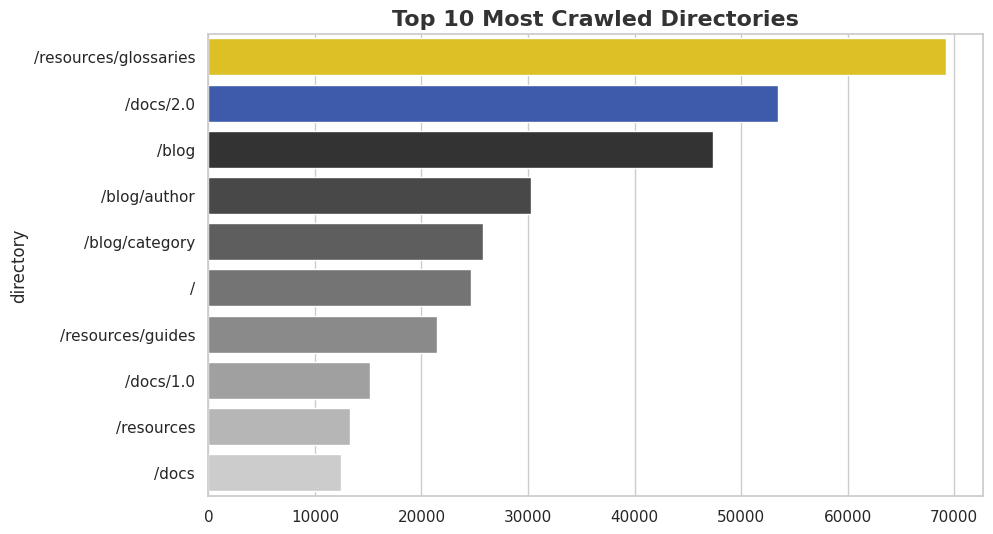

/tmp/ipython-input-1182747385.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bottom_dirs.values, y=bottom_dirs.index, palette=colors)


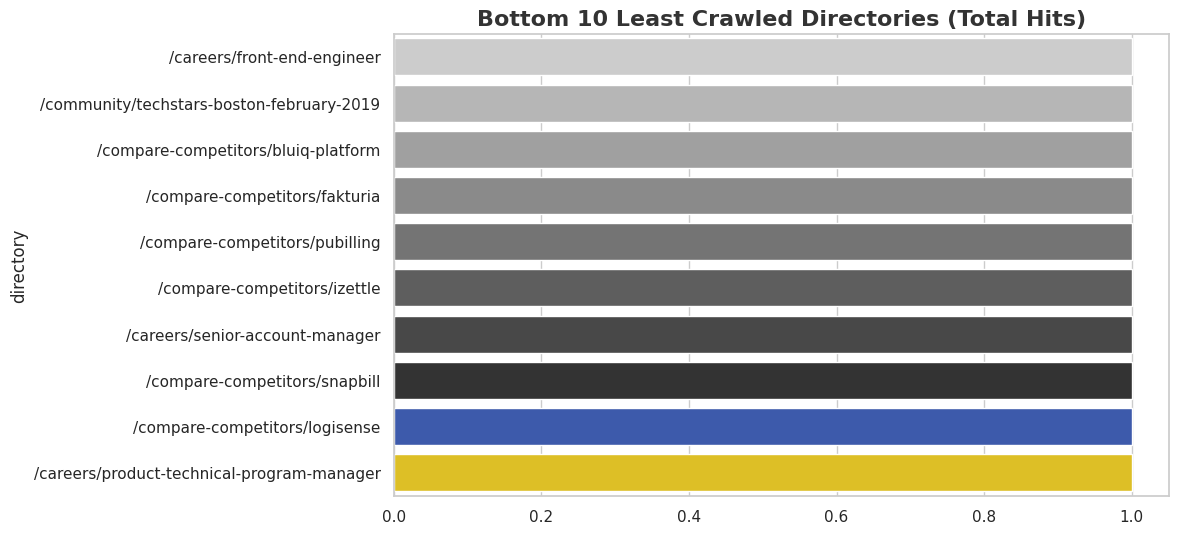

/tmp/ipython-input-1182747385.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bottom_relative['hits_per_page'].values, y=bottom_relative['directory'].values, palette=colors)


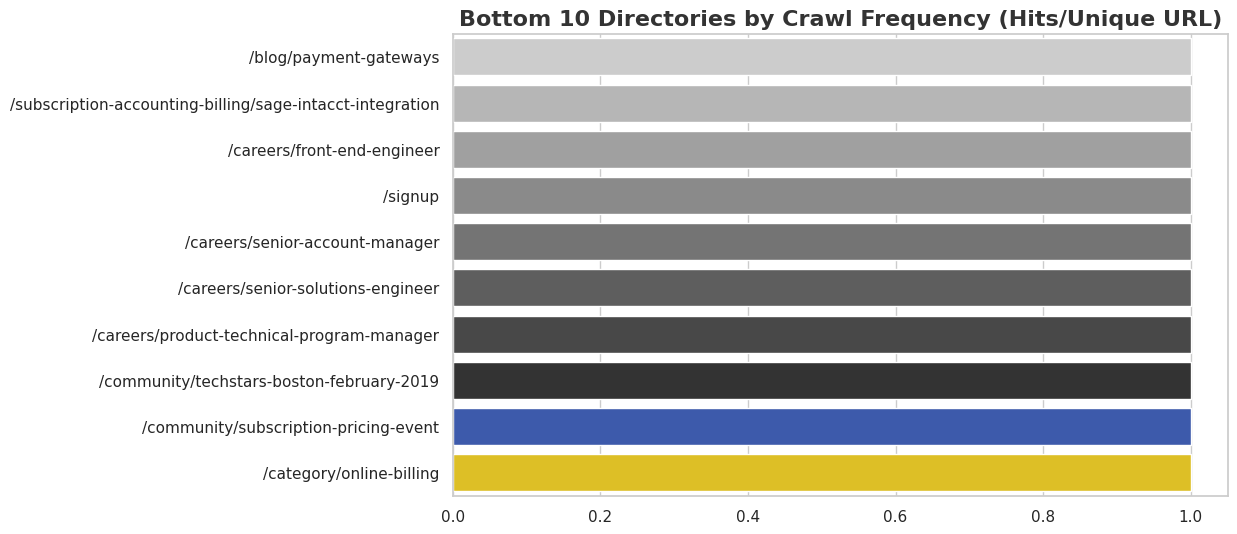

/tmp/ipython-input-1182747385.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_latency.values, y=avg_latency.index, palette=colors)


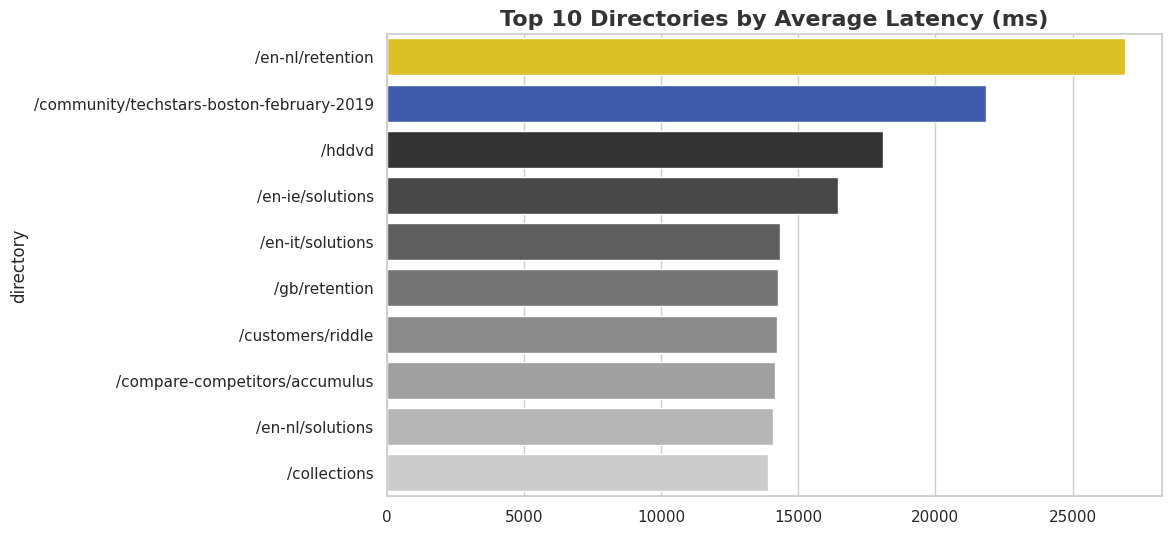

/tmp/ipython-input-1182747385.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_bandwidth.values, y=total_bandwidth.index, palette=colors)


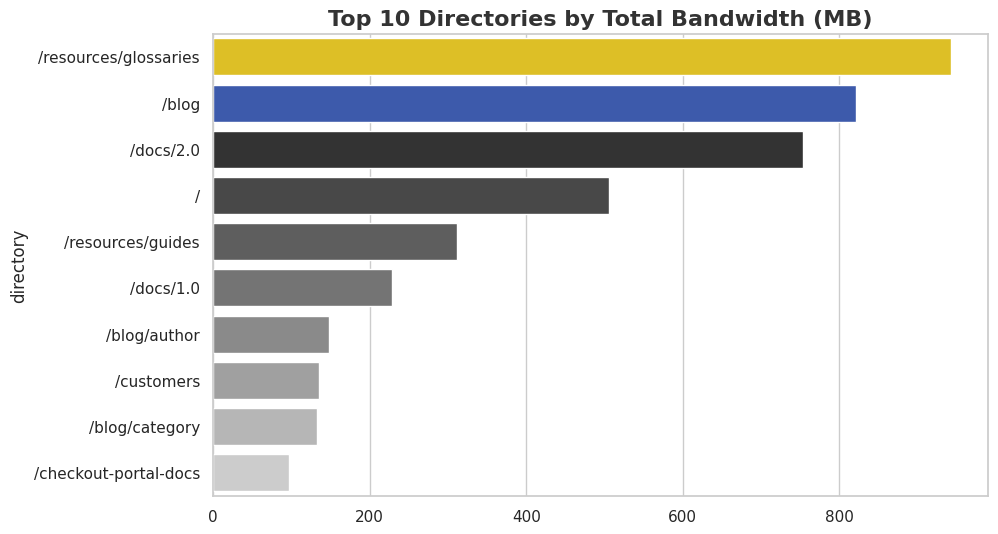

/tmp/ipython-input-1182747385.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=error_counts.values, y=error_counts.index, palette=colors)


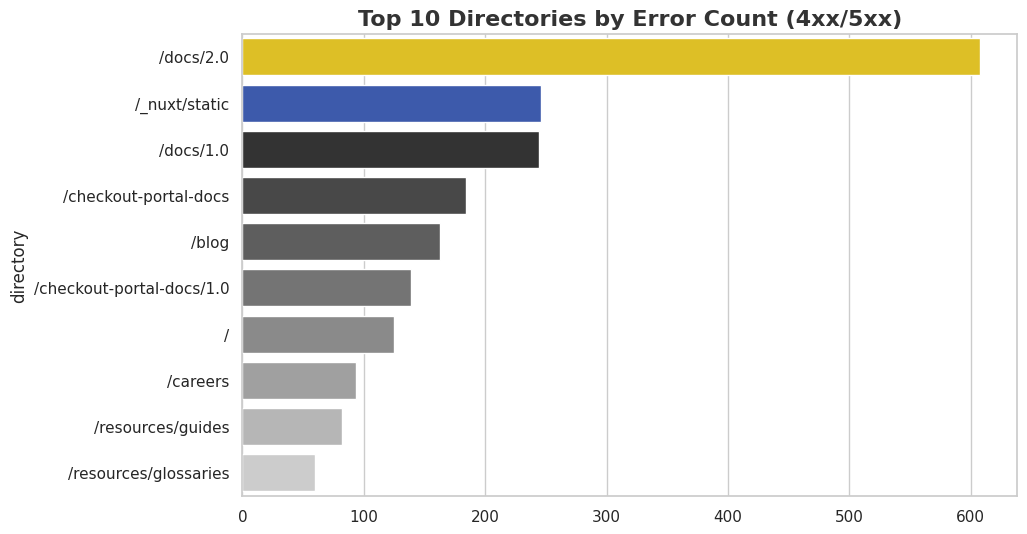

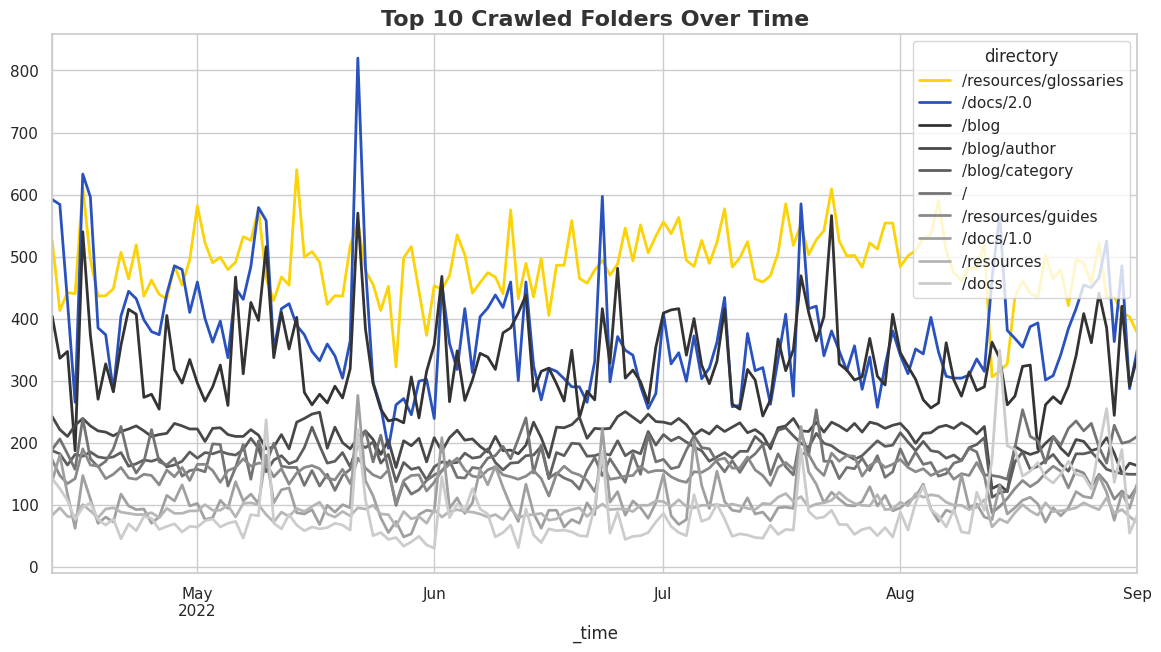

Directory Performance Summary (Latency & Bandwidth vs Site Average):


,Latency_Min,Latency_Max,Latency_Mean,Latency_Median,Latency_Std Dev,Latency_Total Count,Latency_Above +2SD,Latency_+1SD to +2SD,Latency_-1SD to +1SD,Latency_-2SD to -1SD,...,Bandwidth_Max,Bandwidth_Mean,Bandwidth_Median,Bandwidth_Std Dev,Bandwidth_Total Count,Bandwidth_Above +2SD,Bandwidth_+1SD to +2SD,Bandwidth_-1SD to +1SD,Bandwidth_-2SD to -1SD,Bandwidth_Below -2SD
directory,,,,,,,,,,,,,,,,,,,,,
/blog,102.0,143298.0,4023.714240,4978.0,3797.175883,47330.0,467.0,3402.0,43461.0,0.0,...,63309.0,18196.388274,25231.0,14176.197832,47330.0,0.0,0.0,47330.0,0.0,0.0
/resources,114.0,34613.0,1105.584641,184.0,2838.212751,13256.0,93.0,526.0,12637.0,0.0,...,68832.0,6890.969599,3751.0,14201.661816,13256.0,0.0,0.0,13256.0,0.0,0.0
/docs/1.0,117.0,41418.0,3745.054054,3833.0,2323.319354,15133.0,51.0,280.0,14802.0,0.0,...,33944.0,15831.044010,17495.0,6725.626912,15133.0,0.0,0.0,15133.0,0.0,0.0
/resources/glossaries,119.0,93817.0,2515.765660,195.0,4830.417523,69271.0,1914.0,7948.0,59409.0,0.0,...,76467.0,14274.854181,3817.0,23609.340495,69271.0,0.0,0.0,69271.0,0.0,0.0
/blog/category,111.0,41053.0,974.913827,177.0,2162.142155,25739.0,36.0,251.0,25452.0,0.0,...,63309.0,5416.222270,3751.0,8717.897123,25739.0,0.0,0.0,25739.0,0.0,0.0
/resources/guides,120.0,72755.0,2679.824006,192.0,5086.722691,21478.0,710.0,2696.0,18072.0,0.0,...,85029.0,15223.562110,3817.0,24937.032723,21478.0,0.0,0.0,21478.0,0.0,0.0
/newsletter,134.0,21502.0,3572.453545,1891.5,3676.557370,818.0,10.0,65.0,743.0,0.0,...,57236.0,19869.430318,8171.0,19227.687004,818.0,0.0,0.0,818.0,0.0,0.0
/subscription-management/saas-trial-management,158.0,40953.0,8740.478788,9738.5,7755.283774,330.0,59.0,141.0,130.0,0.0,...,79317.0,43566.781818,59578.0,32292.517839,330.0,0.0,0.0,330.0,0.0,0.0
/docs/2.0,124.0,154816.0,3073.825172,2987.0,2260.278468,53487.0,104.0,762.0,52621.0,0.0,...,36888.0,14770.095294,16980.0,7142.137351,53487.0,0.0,0.0,53487.0,0.0,0.0


In [12]:
def get_directory(path, depth=1, folders_set=None):
    if pd.isna(path) or path == '/': return '/'
    parts = [p for p in path.split('/') if p]
    if not parts: return '/'

    # If no folders_set is provided, we can't do smart detection, fall back to simple depth
    if folders_set is None:
        d = depth if depth is not None else len(parts)
        return '/' + '/'.join(parts[:d])

    # Try to find the longest prefix that is a confirmed folder, up to the desired depth
    max_d = depth if depth is not None else len(parts)
    for i in range(min(len(parts), max_d), 0, -1):
        prefix = '/' + '/'.join(parts[:i])
        if prefix in folders_set:
            return prefix

    return '/'

# Identify all confirmed folders (paths that contain other resources)
unique_paths = df['uri_path'].unique()
confirmed_folders = set()
for path in unique_paths:
    if pd.isna(path): continue
    parts = [p for p in path.split('/') if p]
    # Every prefix of a path is a folder that contains the subsequent part
    for i in range(1, len(parts)):
        confirmed_folders.add('/' + '/'.join(parts[:i]))

# Use the global folders set to accurately identify directories limiting depth to 1 level
df['directory'] = df['uri_path'].apply(lambda x: get_directory(x, depth=1, folders_set=confirmed_folders))

# Filter to include only HTML pages for directory crawl analysis (exclude static assets as requested)
df_dir_analysis = df[df['file_type'] == 'HTML'].copy()

# 1. Top 10 Most Crawled Directories
top_dirs = df_dir_analysis['directory'].value_counts().head(10)
plt.figure(figsize=(10, 6))
colors = get_ipr_colors(len(top_dirs), values=top_dirs.values)
sns.barplot(x=top_dirs.values, y=top_dirs.index, palette=colors)
plt.title('Top 10 Most Crawled Directories', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.show()

# 2. Bottom Least Crawled Directories (Hits = 1 or Bottom 10)
dir_counts = df_dir_analysis['directory'].value_counts()
bottom_dirs = dir_counts[dir_counts == 1]
if len(bottom_dirs) < 10: bottom_dirs = dir_counts.tail(10)

bottom_dirs_vis = bottom_dirs.tail(20) # Limit visualization
plt.figure(figsize=(10, 6))
colors = get_ipr_colors(len(bottom_dirs_vis), values=bottom_dirs_vis.values)
sns.barplot(x=bottom_dirs_vis.values, y=bottom_dirs_vis.index, palette=colors)
plt.title('Least Crawled Directories (Total Hits)', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.show()

# 3. Least Crawled Relative to Size (Hits / Unique URLs)
dir_stats = df_dir_analysis.groupby('directory').agg(
    hits=('full_url', 'count'),
    unique_urls=('full_url', 'nunique')
).reset_index()
dir_stats['hits_per_page'] = dir_stats['hits'] / dir_stats['unique_urls']
bottom_relative = dir_stats[dir_stats['hits_per_page'] == 1]
if len(bottom_relative) < 10: bottom_relative = dir_stats.sort_values('hits_per_page').head(10)

bottom_rel_vis = bottom_relative.head(20) # Limit visualization
plt.figure(figsize=(10, 6))
colors = get_ipr_colors(len(bottom_rel_vis), values=bottom_rel_vis['hits_per_page'].values)
sns.barplot(x=bottom_rel_vis['hits_per_page'].values, y=bottom_rel_vis['directory'].values, palette=colors)
plt.title('Bottom Directories by Crawl Frequency (Hits/Unique URL)', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.show()

# 4. Performance: Top 10 Directories by Average Latency (ms)
avg_latency = df_dir_analysis.groupby('directory')['time_taken'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
colors = get_ipr_colors(len(avg_latency), values=avg_latency.values)
sns.barplot(x=avg_latency.values, y=avg_latency.index, palette=colors)
plt.title('Top 10 Directories by Average Latency (ms)', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.show()

# 5. Bandwidth: Top 10 Directories by Total Bandwidth (MB)
total_bandwidth = (df_dir_analysis.groupby('directory')['bytes_sent'].sum() / (1024 * 1024)).sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
colors = get_ipr_colors(len(total_bandwidth), values=total_bandwidth.values)
sns.barplot(x=total_bandwidth.values, y=total_bandwidth.index, palette=colors)
plt.title('Top 10 Directories by Total Bandwidth (MB)', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.show()

# 6. Errors: Top 10 Directories by Error Count (4xx/5xx)
df_dir_analysis['is_error'] = df_dir_analysis['status'].apply(lambda x: x >= 400)
error_counts = df_dir_analysis.groupby('directory')['is_error'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
colors = get_ipr_colors(len(error_counts), values=error_counts.values)
sns.barplot(x=error_counts.values, y=error_counts.index, palette=colors)
plt.title('Top 10 Directories by Error Count (4xx/5xx)', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.show()

top_10_dir_list = top_dirs.index.tolist()
dir_time_series = df_dir_analysis[df_dir_analysis['directory'].isin(top_10_dir_list)].groupby(['directory']).resample('D').size().unstack(0).fillna(0)
plt.figure(figsize=(14, 7))
line_colors = get_ipr_colors(len(top_10_dir_list), values=[top_dirs[d] for d in top_10_dir_list])
dir_time_series[top_10_dir_list].plot(ax=plt.gca(), color=line_colors, linewidth=2)
plt.title('Top 10 Crawled Folders Over Time', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.show()
# Calculate global benchmarks for performance (HTML only)

# Calculate summary statistics for ALL directories
dir_perf_list = []
for directory in df_dir_analysis['directory'].unique():
    dir_data = df_dir_analysis[df_dir_analysis['directory'] == directory]
    l_stats = calculate_summary_stats(dir_data['time_taken'], global_latency_mean, global_latency_std)
    l_stats.index = ['Latency_' + str(x) for x in l_stats.index]
    b_stats = calculate_summary_stats(dir_data['bytes_sent'], global_bandwidth_mean, global_bandwidth_std)
    b_stats.index = ['Bandwidth_' + str(x) for x in b_stats.index]
    combined = pd.concat([l_stats, b_stats])
    combined['directory'] = directory
    dir_perf_list.append(combined)

dir_performance_summary_df = pd.DataFrame(dir_perf_list).set_index('directory')
print("Directory Performance Summary (Latency & Bandwidth vs Site Average):")
display(dir_performance_summary_df.head(20))


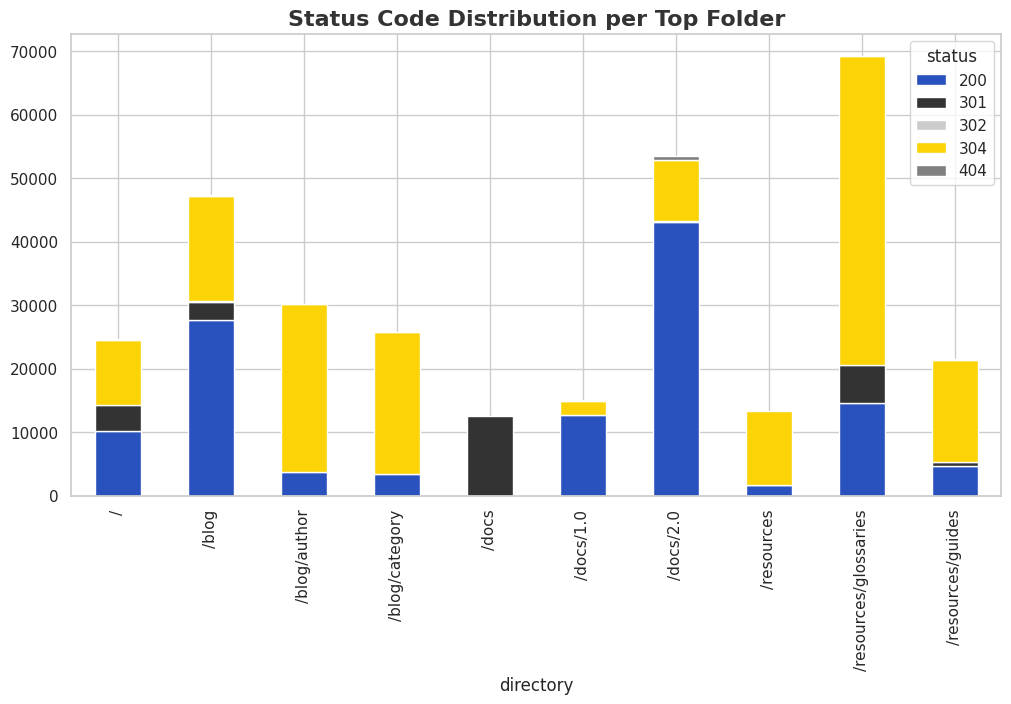

In [13]:
folder_status = df_dir_analysis[df_dir_analysis['directory'].isin(top_dirs.index)].groupby(['directory', 'status']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
global_status_counts = df_dir_analysis['status'].value_counts()
status_colors = get_ipr_colors(len(global_status_counts), values=global_status_counts.values)
status_color_map = dict(zip(global_status_counts.index, status_colors))
plot_colors = [status_color_map.get(s, '#CCCCCC') for s in folder_status.columns]
folder_status.plot(kind='bar', stacked=True, ax=plt.gca(), color=plot_colors)
plt.title('Status Code Distribution per Top Folder', color=IPR_GREY, fontsize=16, fontweight="bold")
plt.show()

In [15]:
def export_all_to_sheets(dataset_list):
    auth.authenticate_user()
    creds, _ = default()
    gc_sheet = gspread.authorize(creds)

    try:
        sh = gc_sheet.open(OUTPUT_SHEET_NAME)
    except gspread.SpreadsheetNotFound:
        sh = gc_sheet.create(OUTPUT_SHEET_NAME)

    timestamp = datetime.now().strftime("%m/%d %H:%M")

    # Create a new worksheet for this consolidated run
    # Increased columns to 100 for horizontal arrangement
    ws = sh.add_worksheet(title=f"Analysis {timestamp}", rows=2000, cols=200)

    curr_col = 1
    for title, df in dataset_list:
        if df is None:
            continue
        if isinstance(df, pd.Series):
            df = df.reset_index()
        if df.empty:
            continue

        # Write Title at Row 1
        title_cell = rowcol_to_a1(1, curr_col)
        ws.update(range_name=title_cell, values=[[title]])

        # Prepare Header and Data
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = ['_'.join([str(c) for c in col]).strip() for col in df.columns.values]

        # Convert datetimes to simple strings (m/d/yy) for better chart display
        # Also convert any lists or dictionaries to string representations
        for col in df.columns:
            if pd.api.types.is_datetime64_any_dtype(df[col]):
                df[col] = df[col].dt.strftime('%m/%d/%y')
            # Check if any element in the column is a list or dictionary
            # and convert the entire column to string type if so.
            elif df[col].apply(lambda x: isinstance(x, (list, dict))).any():
                df[col] = df[col].astype(str)


        header = [f"'{col}" for col in df.columns.tolist()]
        # Use empty strings for NaNs to ensure JSON compliance and preserve empty cells in sheets
        data = df.fillna('').values.tolist()

        # Write Header and Data starting at Row 2
        data_cell = rowcol_to_a1(2, curr_col)
        ws.update(range_name=data_cell, values=[header] + data, value_input_option='USER_ENTERED')

        # Move to next starting column: width of current DF + 1 empty column
        curr_col += len(df.columns) + 1

    print(f"All datasets exported successfully! URL: {sh.url}")

# Construct the list of all datasets for export
export_list = [
    ("Total Hits (Daily)", total_daily_hits.reset_index() if 'total_daily_hits' in locals() else None),
    ("Total Hits (Daily) Summary Stats", daily_hits_summary_df.reset_index() if 'daily_hits_summary_df' in locals() else None),
    ("Total Hits (Weekly)", total_weekly_hits.reset_index() if 'total_weekly_hits' in locals() else None),
    ("Total Hits (Weekly) Summary Stats", weekly_hits_summary_df.reset_index() if 'weekly_hits_summary_df' in locals() else None),
    ("Bot Type Breakdown", bot_counts if 'bot_counts' in locals() else None),
    ("Bot Type Trends (Daily)", bot_time_series.reset_index() if 'bot_time_series' in locals() else None),
    ("Bot Type Summary Stats", bot_summary_df.reset_index() if 'bot_summary_df' in locals() else None),
    ("robots.txt Analysis", robots_summary_df if 'robots_summary_df' in locals() else None),
    ("Status Code Summary", status_summary.reset_index() if 'status_summary' in locals() else None),
    ("Status Code Trends (Daily)", status_time_series.reset_index() if 'status_time_series' in locals() else None),
    ("Status Code Summary Stats", status_code_summary_df.reset_index() if 'status_code_summary_df' in locals() else None),
    ("Cache & New Page Analysis", cache_summary_df.reset_index() if 'cache_summary_df' in locals() else None),
    ("Spider Trap Analysis", trap_details_df if 'trap_details_df' in locals() else None),
    ("Spider Trap Summary Stats", trap_summary_df.reset_index() if 'trap_summary_df' in locals() else None),
    ("Rendering Budget Impact", budget_impact if 'budget_impact' in locals() else None),
    ("Rendering Budget Summary Stats", budget_summary_df.reset_index() if 'budget_summary_df' in locals() else None),
    ("Largest Requests Breakdown", largest_requests_df if 'largest_requests_df' in locals() else None),
    ("Top Most Crawled Directories", top_dirs if 'top_dirs' in locals() else None),
    ("Bottom Directories (Least Crawled)", bottom_dirs if 'bottom_dirs' in locals() else None),
    ("Bottom Directories (Crawl Frequency)", bottom_relative if 'bottom_relative' in locals() else None),
    ("Top 10 Directories (Latency)", avg_latency if 'avg_latency' in locals() else None),
    ("Top 10 Directories (Bandwidth)", total_bandwidth if 'total_bandwidth' in locals() else None),
    ("Top 10 Directories (Errors)", error_counts if 'error_counts' in locals() else None),
    ("Folder Trends (Daily)", dir_time_series.reset_index() if 'dir_time_series' in locals() else None),
    ("Folder Performance Summary", dir_performance_summary_df.reset_index() if 'dir_performance_summary_df' in locals() else None),
    ("Status Code Distribution per Folder", folder_status.reset_index() if 'folder_status' in locals() else None)
]

export_all_to_sheets(export_list)

All datasets exported successfully! URL: https://docs.google.com/spreadsheets/d/1Aw_W_2BsyrDx-aLaBKi6qWBYjAaXvNWggaduqzI8Aes
